<br><h1>A1 Report - Regression-Based Analysis </h1>
<h2>Machine Learning - DAT-5303 - FMSBA3 </h2>
By: Sophie Briques<br>
Hult International Business School<br><br><br>

***

### Overview

- Best performing model was a Linear Regression with 15 features with a test score of 0.8279 and a cross validation score with 11 folds at 0.8076
- Optimal features were found using regularization methods such as Lasso and ARD Regression
- It is predicting the log of revenue, therefore when interpreting coefficients, it is important to transform back using 10<sup>(coef)

***

<strong> Case: Apprentice Chef, Inc. </strong> <br>
<i> Audience: Top Executives </i> <br>
<strong> Goal: </strong> understand how much revenue to expect from each customer within their first year of orders <br>
<strong> Target consumer: </strong> busy professional, little to no skills in the kitchen <br>
<strong> Product: </strong> daily-prepared gourmet meals delivered <br>
<strong>Channels: </strong> online platform and mobile app <br> 
<strong>Revenue: </strong> 90% of revenue comes from customers that have been ordering for 12 months or less


<br> Specifications: 
- at most 30 min to finish cooking
- disposable cookware
- delicious and healthy eating
<br> Channels: online platform and mobile app
Revenue: 90% of revenue comes from customers that have been ordering for 12 months or less





***
<strong> Data and Assumptions </strong> <br>
Dataset:
<br> 2,000 customers (approx.)
- at least one purchase per month for a total of 11 of their first 12 months
- at least one purchase per quarter and at least 15 purchases through their first year
- dataset engineering techniques are statistically sound and represent the customers


Assumptions:
- all average times are in seconds
- revenue = price x quantity and total meals ordered represent quantity
- when customers attend master classes, they are looking to increase their cooking skills

***
<strong> Outline: </strong>
1. Part 1: Exploratory Data Analysis
2. Part 2: Transformations
3. Part 3: Build a machine learning model to predict revenue 
4. Part 4: Evaluating Model



In [1]:
# Importing Necessary Libraries
import pandas                  as pd  # data science essentials
import matplotlib.pyplot       as plt # essential graphical output
import seaborn                 as sns # enhanced graphical output
import statsmodels.formula.api as smf # regression modeling
from   sklearn.model_selection import train_test_split    # train test split
from   sklearn.neighbors       import KNeighborsRegressor # KNN for Regression
from   sklearn.preprocessing   import StandardScaler      # standard scaler
from   sklearn.linear_model    import LinearRegression    # linear regression (scikit-learn)
from   sklearn.model_selection import cross_val_score     # cross-validation 
import sklearn
import numpy as np
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file name
file = "Apprentice_Chef_Dataset.xlsx"


# reading the file into Python
original_df = pd.read_excel(file)
chef_org = original_df.copy()

## Part 1: Exploratory Data Analysis (EDA)

In [2]:
#################################################
##########  User-Defined Functions    ###########
#################################################

# Defining function for distribution histograms
def continuous_distributions(variable, data, bins = 'fd', kde = False, rug = False):
    """
    This function can be used for continuous variables

    PARAMETERS
    ----------
    variable : str, continuous variable
    data     : DataFrame of the response and categorical variables.
    bins     : argument for matplotlib hist(), optional. If unspecified, Freedman–Diaconis rule is used.
    kde      : bool, optional, plot or not a kernel density estimate.  If unspecified, not calculated.
    rug      : bool, optional, include a rug on plot or not. If unspecified, not shown.
    """

    sns.distplot(data[variable],  
                    bins  = bins,
                    kde   = False,
                    rug   = rug,
                    color = 'g')
    
    plt.xlabel(variable)
    plt.tight_layout()
    plt.show()

# Defining function to flag high outliers in variables
def outlier_flag_hi(variable, threshold, data):
    """
    This function is used to flag high outliers in a dataframe the variables' 
    outliers by creating a new column that is preceded by 'out_'.

    PARAMETERS
    ----------
    variable  : str, continuous variable.
    threshold : float, value that will identify where outliers would be.
    data      : dataframe, where the variables are located.
    
    """
    # creating a new column
    data['out_' + variable] = 0
        
    # defining outlier condition
    high = data.loc[0:,'out_' + variable][data[variable] > threshold]
        
    # imputing 1 inside flag column
    data['out_' + variable].replace(to_replace = high,
                                    value   = 1,
                                    inplace = True)

    


# Defining function to flag high outliers in variables
def outlier_flag_lo(variable, threshold, data):
    """
    This function is used to flag low outliers in a dataframe the variables' 
    outliers by creating a new column that is preceded by 'out_'.

    PARAMETERS
    ----------
    variable  : str, continuous variable.
    threshold : float, value that will identify where outliers would be.
    data      : dataframe, where the variables are located.
    
    """
    # creating a new column
    data['out_' + variable] = 0
        
    # defining outlier condition
    low = data.loc[0:,'out_' + variable][data[variable] < threshold]
        
    # imputing 1 inside flag column
    data['out_' + variable].replace(to_replace = low,
                                    value   = 1,
                                    inplace = True)
    

# Defining function for relationship scatterplots
def scatterplots(independ_var, target_var, data, color = 'g'):
    """
    This function can be used for continuous variables

    PARAMETERS
    ----------
    independ_var : str, continuous variable
    target_var : str, continuous variable we are trying to predict
    data       : DataFrame of the response and categorical variables.
    color      : str, optional. If unspecified, green color is used.
    """

    sns.scatterplot(x = data[independ_var],
                    y = data[target_var],
                    color = color)
    plt.xlabel(independ_var)
    plt.tight_layout()
    plt.show()


# Defining function to flag higher variables
def higher_change_flag(variable, index, threshold, data):
    """
    This function is used to flag in a dataframe the variables' trend changes above a threshold by creating
    a new column that is preceded by 'change_'.

    PARAMETERS
    ----------
    variable  : str, continuous variable.
    threshold : float, value that will identify after which the trend on variable y changes
    data      : dataframe, where the variables are located.
    
    """
    new_column = 'change_' + variable + "_" + str(index)
    
    # creating a new column
    data[new_column] = 0
        
    # defining outlier condition
    high = data.loc[0:,new_column][data[variable] > threshold]
        
    # imputing 1 inside flag column
    data[new_column].replace(to_replace = high,
                                       value   = 1,
                                       inplace = True)
    

    
# Defining function to flag change at variables
def at_flag(variable, index, threshold, data):
    """
    This function is used to flag in a dataframe the variables' trend changes at a threshold by creating
    a new column that is preceded by 'change_'.

    PARAMETERS
    ----------
    variable  : str, continuous variable.
    threshold : float, value that will identify after which the trend on variable y changes
    data      : dataframe, where the variables are located.
    
    """
    new_column = 'change_' + variable + "_" + str(index)
    
    # creating a new column
    data[new_column] = 0
        
    # defining outlier condition
    high = data.loc[0:,new_column][data[variable] == threshold]
        
    # imputing 1 inside flag column
    data[new_column].replace(to_replace = high,
                                       value   = 1,
                                       inplace = True)
    


In [3]:
# Printing information on our dataset and its columns
# pulling up data dictionary
chef_description = pd.read_excel('Apprentice_Chef_Data_Dictionary.xlsx')

# Displaying:
#chef_description
#chef_org.info()
#chef_org.describe()


<strong> Observations: </strong>
- Data types are coherent with each variable description
- 47 missing values in Family Name
- Number of observations: 1946
- Total of 28 variables (including target variable) where:
    - 3 are floats
    - 22 are integers
    - 4 are objects

<strong> Step 1: </strong> Classifying our variables based on variable types:

In [4]:
"""
# CONTINUOUS OR INTERVAL
REVENUE                     
AVG_TIME_PER_SITE_VISIT        
FOLLOWED_RECOMMENDATIONS_PCT
AVG_PREP_VID_TIME
LARGEST_ORDER_SIZE
MEDIAN_MEAL_RATING             (interval)
AVG_CLICKS_PER_VISIT

# BINARY
CROSS_SELL_SUCCESS     (target variable)
MOBILE_NUMBER          (also categorical)
TASTES_AND_PREFERENCES (also categorical)
PACKAGE_LOCKER         (also categorical)
REFRIGERATED_LOCKER    (also categorical)

# COUNT
TOTAL_MEALS_ORDERED
UNIQUE_MEALS_PURCH
CONTACTS_W_CUSTOMER_SERVICE
PRODUCT_CATEGORIES_VIEWED
CANCELLATIONS_BEFORE_NOON
CANCELLATIONS_AFTER_NOON
MOBILE_LOGINS
PC_LOGINS
WEEKLY_PLAN
EARLY_DELIVERIES
LATE_DELIVERIES
MASTER_CLASSES_ATTENDED
TOTAL_PHOTOS_VIEWED

# CATEGORICAL
CROSS_SELL_SUCCESS     (also binary)
MOBILE_NUMBER          (also binary)
TASTES_AND_PREFERENCES (also binary)
PACKAGE_LOCKER         (also binary)
REFRIGERATED_LOCKER    (also binary)

# DISCRETE
NAME
EMAIL
FIRST_NAME
FAMILY_NAME

"""
categorical = ['CROSS_SELL_SUCCESS',
               'MOBILE_NUMBER',
               'TASTES_AND_PREFERENCES',
               'PACKAGE_LOCKER',
               'REFRIGERATED_LOCKER']

continuous = ['REVENUE',
              'AVG_TIME_PER_SITE_VISIT',
              'FOLLOWED_RECOMMENDATIONS_PCT',
              'AVG_PREP_VID_TIME',
              'LARGEST_ORDER_SIZE',
              'MEDIAN_MEAL_RATING',
              'AVG_CLICKS_PER_VISIT']

counts = ['TOTAL_MEALS_ORDERED',
          'UNIQUE_MEALS_PURCH',
          'CONTACTS_W_CUSTOMER_SERVICE',
          'PRODUCT_CATEGORIES_VIEWED',
          'CANCELLATIONS_BEFORE_NOON',
          'CANCELLATIONS_AFTER_NOON',
          'MOBILE_LOGINS',
          'PC_LOGINS',
          'WEEKLY_PLAN',
          'EARLY_DELIVERIES',
          'LATE_DELIVERIES',
          'MASTER_CLASSES_ATTENDED',
          'TOTAL_PHOTOS_VIEWED']

### A) Missing Value Analysis and Imputation


<strong> Step 2: </strong> Further investigating missing values

In [5]:
# Inspecting missing values
#chef_org.isnull().sum()
#chef_org.loc[:,:][chef_org['FAMILY_NAME'].isna()]

<strong>Observations: </strong>
- Customers that have NA family name have parenthesis in names
- Parenthesis seem to indicate either their role or their geographical location
- Emails take the same format for last name 
<br><br>

<strong> Conclusion: </strong> not enough information to impute last name, leave as NA and flag where they are since last name is a discrete variable that most probably will not bring insights to the purpose of this analysis.

In [6]:
# Flagging missing variables for FAMILY_NAME
# creating a copy of dataframe for safety measures
chef_m = chef_org.copy()

# creating a new column where 1 indicates that observation has a missing family name
chef_m['m_FAMILY_NAME'] = chef_m['FAMILY_NAME'].isnull().astype(int)

### B) Categorical Variables - Sample Size Check


<strong> Step 3: </strong> Checking for sample size for each of categorical/ binary variables. We need to see if the size of each of the categories is large enough to infer statistical significance or insignificance. If not, the variable could be insignificant to predict revenue when in reality its sample size is too small.

In [7]:
for variable in chef_org:
    if variable in categorical:
        print(f"""{variable}
------
{chef_org[variable].value_counts()}
          
    """)

CROSS_SELL_SUCCESS
------
1    1321
0     625
Name: CROSS_SELL_SUCCESS, dtype: int64
          
    
MOBILE_NUMBER
------
1    1708
0     238
Name: MOBILE_NUMBER, dtype: int64
          
    
TASTES_AND_PREFERENCES
------
1    1390
0     556
Name: TASTES_AND_PREFERENCES, dtype: int64
          
    
PACKAGE_LOCKER
------
0    1255
1     691
Name: PACKAGE_LOCKER, dtype: int64
          
    
REFRIGERATED_LOCKER
------
0    1726
1     220
Name: REFRIGERATED_LOCKER, dtype: int64
          
    


<strong> Observations: </strong>
- Sample size for each option in all categorical variables are large enough for analysis (all contain above 200 observations)


### C) Categorical Variables: Email Domains

<strong> Purpose </strong>: email domains from clients can provide insight on which customers are more likely to open any email communications. For example, if the email used for subscription is a "junk" email, chances are this customer might look at the inbox as often as we would like, as opposed to a professional email address where the customer might be looking at it multiple times a day. This can lead to an affect in revenue since clients might order a meal through an advertisement or a discount. <br>
<br> This steps first selects the email domain for each customer, then creates a new categorical variable where each domain is classified as "personal", "professional" or "junk". Finally, we will be one-hot encoding this new variable which will create three new columns for each email category. In these new columns, if an email corresponds to the column, that observation will take on the value 1.

In [8]:
# STEP 1: splitting emails
# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef_org.iterrows():
    
    # splitting email domain at '@'
    split_email = chef_m.loc[index, 'EMAIL'].split(sep = '@')

    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    
# converting placeholder_lst into a DataFrame
email_df = pd.DataFrame(placeholder_lst)

# STEP 2: concatenating with original DataFrame
# Creating a copy of chef for features and safety measure
chef = chef_m.copy()

# renaming column to concatenate
email_df.columns = ['name' , 'EMAIL_DOMAIN'] 

# concatenating personal_email_domain with chef DataFrame
chef = pd.concat([chef, email_df.loc[:, 'EMAIL_DOMAIN']], 
                   axis = 1)

# printing value counts of personal_email_domain
chef.loc[: ,'EMAIL_DOMAIN'].value_counts()

# email domain types
professional_email_domains = ['@mmm.com',         '@amex.com',
                              '@apple.com',       '@boeing.com',
                              '@caterpillar.com', '@chevron.com',
                              '@cisco.com',       '@cocacola.com',
                              '@disney.com',      '@dupont.com',
                              '@exxon.com',       '@ge.org',
                              '@goldmansacs.com', '@homedepot.com',
                              '@ibm.com',         '@intel.com',
                              '@jnj.com',         '@jpmorgan.com',
                              '@mcdonalds.com',   '@merck.com',
                              '@microsoft.com',   '@nike.com',
                              '@pfizer.com',      '@pg.com',
                              '@travelers.com',   '@unitedtech.com',
                              '@unitedhealth.com','@verizon.com',
                              '@visa.com',        '@walmart.com']
personal_email_domains     = ['@gmail.com',       '@yahoo.com',    
                              '@protonmail.com']
junk_email_domains         = ['@me.com',          '@aol.com',
                              '@hotmail.com',     '@live.com', 
                              '@msn.com',         '@passport.com']

# placeholder list
placeholder_lst = []  


# looping to group observations by domain type
for domain in chef['EMAIL_DOMAIN']:
        if "@" + domain in professional_email_domains:
            placeholder_lst.append('professional')
            
        elif "@" + domain in personal_email_domains:
            placeholder_lst.append('personal')
            
        elif "@" + domain in junk_email_domains:
            placeholder_lst.append('junk')
            
        else:
            print('Unknown')


# concatenating with original DataFrame
chef['email_domain_group'] = pd.Series(placeholder_lst)

# checking results and sample size
#print(chef['email_domain_group'].value_counts())

# Step 3: One-Hot encoding
one_hot_email_domain = pd.get_dummies(chef['email_domain_group'])

# dropping orginal columns to keep only encoded ones
chef_1               = chef.drop(['email_domain_group','EMAIL','EMAIL_DOMAIN'], axis = 1)

# joining encoded columns to dataset
chef_1               = chef_1.join(one_hot_email_domain)

# including new categorical variables to list
domains              = ['professional','personal','junk']
categorical          = categorical + domains


### D) Continuous Variables: Outliers Detection

<strong> Purpose: </strong> Outliers affect most predictive models. It increases variance in a variable, and therefore need to be flagged for two main reasons: <br> <br>
1) Using outlier flag variable in our model quantifies the affect of that outlier on the variable we are trying to predict (in this case, revenue) <br>
2) In some cases, removing outliers can improve our predictions and increase generalization of our model <br> <br>

<nbsp> <nbsp> <nbsp> <nbsp>  In the following code, we visualize each variable's distribution with an user-defined function and we look at the quartile ranges using descriptive statistics. We then set thresholds which will determine which observations are going to be considered as outliers in this analysis. Finally, we create a new column for each of the variables that contain outliers, where a 1 will be imputed for outlier observations. <br><br>
<i> Note: no outliers are removed in the part of the analysis <i> <br><br>

In [9]:
# Visualizing continuous variable distributions
#for variable in continuous:
#    continuous_distributions(variable, chef_org, bins = 'fd', kde = True, rug = False)

In [10]:
#chef_org[continuous].describe()

<strong> Observations:</strong>
- Revenue:
    - big dip in clients with revenue at approx 2,000 

- Avg Time per Site Visit (in seconds):
    - almost a normal distribution
    - outliers after 200 (3.3 min)
    
- Followed Recommendations Percentage:
    - outliers after 80%
    
- Average Preparation Video Time (in seconds):
    - almost a normal distribution
    - outliers after 250 (approx 4 min)
    
- Largest Order Size:
    - almost normal distribution 
    - after 5: a family is usually 4 - 5 people, more than that it could be that these customers are throwing dinner parties or keeping the meals for the next day

- Median Meal Rating:
    - peak on 3
    - no obvious outliers

- Average Clicks per visit:
    - outliers before 10


In [11]:
## Visualizing count variable distributions
#for variable in counts:
#    continuous_distributions(variable, chef_org, bins = 'auto',kde = False, rug = False)

<strong> Observations: </strong>

- Total Meals Ordered:
    - strong dip in around 25 - investigate
    - outliers after 320
    
- Unique Meals Purchased:
    - outliers after 10
    
- Contacts with customer service:
    - outliers after 13
    
- Product Categories Viewed:
    - no obvious outliers
    
- Cancellations Before Noon:
    - approx exponential distribution
    - outliers after 8
   
- Cancellations After Noon:
    - no obvious outliers
    
- Mobile Log-ins:
    - no obvious outliers
    
- PC Log-ins:
   - no obvious outliers

- Weekly Plan:
    - no obvious outliers

- Early Deliveries:
    - peak on 0
    - no obvious outliers

- Late Deliveries:
    - outliers after 17
    
- Master Class Attended:
    - no obvious outliers
    
- Total Photos Viewed:
    - peak on 0
    - outliers after 800



In [12]:
# Establishing outliers thresholds for analysis
# Continous
avg_time_per_site_visit_hi = 200
avg_prep_vid_time_hi       = 250
followed_rec_hi            = 80
largest_order_size_hi      = 5
avg_clicks_per_visit_lo    = 10



# Counts:
total_meals_ordered_hi            = 320
unique_meals_purchased_hi         = 10
contacts_with_customer_service_hi = 13
cancellations_before_noon_hi      = 8
late_deliveries_hi                = 17
total_photos_viewed_hi            = 800

# Target Variable
revenue_hi  =  5500


# Creating Dictionary to link variables with outlier thresholds
lst_thresholds_hi = {
    'AVG_TIME_PER_SITE_VISIT'      : avg_time_per_site_visit_hi,
    'AVG_PREP_VID_TIME'            : avg_prep_vid_time_hi,
    'TOTAL_MEALS_ORDERED'          : total_meals_ordered_hi,
    'UNIQUE_MEALS_PURCH'           : unique_meals_purchased_hi,
    'CONTACTS_W_CUSTOMER_SERVICE'  : contacts_with_customer_service_hi,
    'CANCELLATIONS_BEFORE_NOON'    : cancellations_before_noon_hi,
    'LATE_DELIVERIES'              : late_deliveries_hi,
    'TOTAL_PHOTOS_VIEWED'          : total_photos_viewed_hi,
    'REVENUE'                      : revenue_hi,
    'FOLLOWED_RECOMMENDATIONS_PCT' : followed_rec_hi,
    'LARGEST_ORDER_SIZE'           : largest_order_size_hi
    }

lst_thresholds_lo = {
     'AVG_CLICKS_PER_VISIT'         : avg_clicks_per_visit_lo
     }

In [13]:
# Looping over variables to create outlier flags:
for key in lst_thresholds_hi.keys():
    outlier_flag_hi(key,lst_thresholds_hi[key],chef_1)
    
for key in lst_thresholds_lo.keys():
    outlier_flag_lo(key,lst_thresholds_lo[key],chef_1)

### E) Continuous/ Count Variables: Trend-Based Features

<strong> Purpose: </strong> Changes in variables behaviors in relation to our target variable can provide powerful explanations in our model as to how our revenue might be afftected. <br> 

<nbsp> <nbsp> <nbsp> <nbsp>  In the following code, we visualize each variable's relationship with revenue with an user-defined function. We then set thresholds which will determine which observations are going to be considered having a differing effect on our revenue. Finally, we create a new feature for each of the variables that contain this difference, where a 1 will be imputed for these observations. <br><br>


In [14]:
# Defining dependent variables for trend analysis
dependent_vars = [
    'AVG_TIME_PER_SITE_VISIT',     'FOLLOWED_RECOMMENDATIONS_PCT',
    'AVG_PREP_VID_TIME',           'LARGEST_ORDER_SIZE',
    'MEDIAN_MEAL_RATING',          'AVG_CLICKS_PER_VISIT',
    'TOTAL_MEALS_ORDERED',         'UNIQUE_MEALS_PURCH',
    'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',
    'CANCELLATIONS_BEFORE_NOON',   'CANCELLATIONS_AFTER_NOON',
    'MOBILE_LOGINS',               'PC_LOGINS',
    'WEEKLY_PLAN',                 'EARLY_DELIVERIES',
    'LATE_DELIVERIES',             'MASTER_CLASSES_ATTENDED',
    'TOTAL_PHOTOS_VIEWED'
    ]

In [15]:
# Visualizing dependent variable scatter plots in relation to Revenue
#for variable in dependent_vars:
#    scatterplots(independ_var = variable, target_var = 'REVENUE', data = chef_org, color = 'r')

Observations:
- AVG_TIME_PER_SITE_VISIT
    - different at 50 seconds
    - 50 seconds to 200 seconds: no trend changes
    - data scatter after 200
    - outlier at 1600
- FOLLOWED_RECOMMENDATIONS_PCT
    - more dispersed after 70 percent
- AVG_PREP_VID_TIME
    - more variance after 150s (how to flag this?)
    - less variance after 210s
    - after 300 less data points
- LARGEST_ORDER_SIZE
    - increase in revenue until 5
    - decrease but less steep after 5
- MEDIAN_MEAL_RATING
    - inflated at 3 and 4
	   - decrease after 4
- AVG_CLICKS_PER_VISIT
    - less than 8 very few data points
	  -  increase in revenue until 10 clicks
    - decrease after 10 until 15
    - 16 to max constant
- TOTAL_MEALS_ORDERED
    - heteroskedasticity
    - at 15 inflated
    - increase at 100 
    - slower increase after 100    
- UNIQUE_MEALS_PURCH
    - inflated at 1: people must be ordering the same thing all the time
    - until 9 - constant
    - after 10 - outliers
- CONTACTS_W_CUSTOMER_SERVICE
    - until 10: revenue increases
    - after 10: revenue decreases
- PRODUCT_CATEGORIES_VIEWED
    - until 5 slow decrease
    - after 5 more constant
- CANCELLATIONS_BEFORE_NOON
    - after 8
- CANCELLATIONS_AFTER_NOON
    - zero inflated
    - at 3 - few observations with big revenue variance
- MOBILE_LOGINS
    - 0 and 1 are increase
    - 2 and 3 decrease
- PC_LOGINS
    - 4 to 6 increase
    - 7 decrease
- WEEKLY_PLAN
    - after 15 seems to be a decrease
    - constant after that
- EARLY_DELIVERIES
    - no obvious trend changes (does not seem to be a problem)
- LATE_DELIVERIES
    - decrease until 8
- MASTER_CLASSES_ATTENDED
    - at 1
    - at 2: less
- TOTAL_PHOTOS_VIEWED
    - 0 inflated

In [16]:
# Establishing outliers thresholds for analysis
# data scatters above this point
AVG_TIME_PER_SITE_VISIT_change_hi      = 200
FOLLOWED_RECOMMENDATIONS_PCT_change_hi = 70
AVG_PREP_VID_TIME_change_lo            = 150
AVG_PREP_VID_TIME_change_hi            = 210
TOTAL_MEALS_ORDERED_change_hi          = 100

# trend changes
LARGEST_ORDER_SIZE_change_hi          = 5
AVG_CLICKS_PER_VISIT_change_lo        = 8
AVG_CLICKS_PER_VISIT_change_hi        = 16
UNIQUE_MEALS_PURCH_change_hi          = 9
CONTACTS_W_CUSTOMER_SERVICE_change_hi = 10
PRODUCT_CATEGORIES_VIEWED_change_hi   = 5
CANCELLATIONS_BEFORE_NOON_change_hi   = 8
MOBILE_LOGINS_change_hi               = 1
PC_LOGINS_change_hi                   = 6
WEEKLY_PLAN_change_hi                 = 15
LATE_DELIVERIES_change_lo             = 8
TOTAL_MEALS_ORDERED_change_hi         = 100


# Different at __ 
AVG_TIME_PER_SITE_VISIT_change_at  = 50
MEDIAN_MEAL_RATING_change_at1      = 3
MEDIAN_MEAL_RATING_change_at2      = 4
MEDIAN_MEAL_RATING_change_at3      = 5
TOTAL_MEALS_ORDERED_change_at      = 15
UNIQUE_MEALS_PURCH_change_at       = 1
CANCELLATIONS_AFTER_NOON_change_at = 0
MASTER_CLASSES_ATTENDED_change_at1  = 1
MASTER_CLASSES_ATTENDED_change_at2  = 2


# Zero Inflated
TOTAL_PHOTOS_VIEWED_change_at = 0 


# Creating Dictionary to link variables with trend thresholds
high_thresholds = {
    'AVG_TIME_PER_SITE_VISIT'        : [AVG_TIME_PER_SITE_VISIT_change_hi],
    'FOLLOWED_RECOMMENDATIONS_PCT'   : [FOLLOWED_RECOMMENDATIONS_PCT_change_hi],
    'AVG_PREP_VID_TIME'              : [AVG_PREP_VID_TIME_change_hi,
                                        AVG_PREP_VID_TIME_change_lo],
    'TOTAL_MEALS_ORDERED'            : [TOTAL_MEALS_ORDERED_change_hi],
    'LARGEST_ORDER_SIZE'             : [LARGEST_ORDER_SIZE_change_hi],
    'AVG_CLICKS_PER_VISIT'           : [AVG_CLICKS_PER_VISIT_change_lo, 
                                        AVG_CLICKS_PER_VISIT_change_hi],
    'UNIQUE_MEALS_PURCH'             : [UNIQUE_MEALS_PURCH_change_hi],
    'CONTACTS_W_CUSTOMER_SERVICE'    : [CONTACTS_W_CUSTOMER_SERVICE_change_hi],
    'PRODUCT_CATEGORIES_VIEWED'      : [PRODUCT_CATEGORIES_VIEWED_change_hi],
    'CANCELLATIONS_BEFORE_NOON'      : [CANCELLATIONS_BEFORE_NOON_change_hi],
    'MOBILE_LOGINS'                  : [MOBILE_LOGINS_change_hi],
    'PC_LOGINS'                      : [PC_LOGINS_change_hi],
    'WEEKLY_PLAN'                    : [WEEKLY_PLAN_change_hi],
    'LATE_DELIVERIES'                : [LATE_DELIVERIES_change_lo],
    'TOTAL_MEALS_ORDERED'            : [TOTAL_MEALS_ORDERED_change_hi]
    }
                     
                     
at_thresholds = {
    'AVG_TIME_PER_SITE_VISIT'      : [AVG_TIME_PER_SITE_VISIT_change_at],
    'MEDIAN_MEAL_RATING'           : [MEDIAN_MEAL_RATING_change_at1, 
                                       MEDIAN_MEAL_RATING_change_at2, 
                                       MEDIAN_MEAL_RATING_change_at3],
    'UNIQUE_MEALS_PURCH'           : [UNIQUE_MEALS_PURCH_change_at],
    'CANCELLATIONS_BEFORE_NOON'    : [CANCELLATIONS_AFTER_NOON_change_at],
    'MASTER_CLASSES_ATTENDED'      : [MASTER_CLASSES_ATTENDED_change_at1,
                                       MASTER_CLASSES_ATTENDED_change_at2],
    'TOTAL_PHOTOS_VIEWED'          : [TOTAL_PHOTOS_VIEWED_change_at]
    }


In [17]:
# Looping over dataset to create trend based columns
for key, value in high_thresholds.items():
    i = 0
    for val in value:
        higher_change_flag(key, i, val, chef_1)
        i += 1

for key, value in at_thresholds.items():
    i = 0
    for val in value:
        at_flag(key, i, val, chef_1)
        i += 1

In [18]:
# Dropping variables after feature engineering
## !! only run this cell once !! ##
clean_chef = chef_1.drop([
                          'CROSS_SELL_SUCCESS',
                          'NAME',
                          'FIRST_NAME',
                          'FAMILY_NAME',
                          'm_FAMILY_NAME'
                         ], axis = 1)

## Part II: Transformations

<strong> Purpose: </strong> In preparation for modeling, it is important to prepare our dataset to the different modeling techniques by using transformation. <br> 
- Explanatory variables: <strong> standardization </strong> is going to be applied to our dependent variables. This is important for models that use distance (variance) to predict the target variable, revenue. By standardizing, we ensure that all dependent variables are on the same scale and can be compared easily. 

- Target Variable: <strong> logarithmic </strong> is going to be applied to our independent variable. The distribution of revenue is skewed to the right. By treating this skewness with a log transformation, we normalize the magnitude of smaller and larger variables. In other words, lower revenues are expanded in our analysis and higher revenues are compressed. In addition, this transformation will decrease the effects of outliers which increases the application of any model to new unseen data.
<br>
<i> Note: log transformations require non-zero values </i><br><br>
sources: <br>
<a> https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114 <br>
<a> https://www.r-statistics.com/2013/05/log-transformations-for-skewed-and-wide-distributions-from-practical-data-science-with-r/ 


In [19]:
#Defining a function to standardize numerical variables in the dataset:

def standard(num_df):
    """
    This function standardizes a dataframe that contains variables which are either
    integers or floats.
    
    ------
    num_df : DataFrame, must contain only numerical variables
    
    """
    # Isolating target variable from DF to be standardized
    #num_df = num_df.drop(target_variable, axis = 1)
    
    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler()

    # FITTING the scaler with housing_data
    scaler.fit(num_df)

    # TRANSFORMING our data after fit
    X_scaled = scaler.transform(num_df)

    # converting scaled data into a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled)
    
    # adding labels to the scaled DataFrame
    X_scaled_df.columns = num_df.columns
    
    # Re-attaching target variable to DataFrame
    #X_scaled_df = X_scaled_df.join(target_variable)
    
    # returning the standardized data frame into the global environment
    return X_scaled_df



In [20]:
# Log Transformation
# creating a copy for safety measures
clean_chef = clean_chef.copy()

#transforming only REVENUE column
clean_chef['rev_log'] = clean_chef['REVENUE'].transform(np.log)


In [21]:
# Standardization
# creating a copy for safety measures
clean_chef = clean_chef.copy()

# dropping revenue from standardization
chef_x      = clean_chef.drop(['REVENUE','rev_log'], axis = 1)
#clean_chef.columns
chef_target = clean_chef.loc[:,['REVENUE','rev_log']]

# standardizing with user defined function and joining target revenue
chef_std   = standard(chef_x).join(chef_target)

## Part III: Modelling

<strong> Purpose: </strong> Find a model that can predict a new customer's revenue.

In [22]:
# Defining a dictionary with variables names for each different model test

variables_dict = {
    "Base" : [ # will only work with chef_org
        'REVENUE', 'CROSS_SELL_SUCCESS', 'NAME', 'EMAIL', 'FIRST_NAME', 
        'FAMILY_NAME', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
        'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 
        'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
        'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS',
        'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT',
        'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED',
        'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED'
    ],
    "Full_Features" : [
        'REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
        'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 
        'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
        'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 
        'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT',
        'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 
        'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED', 
        'junk', 'personal', 'professional', 'out_AVG_TIME_PER_SITE_VISIT', 
        'out_AVG_PREP_VID_TIME', 'out_TOTAL_MEALS_ORDERED', 'out_UNIQUE_MEALS_PURCH', 
        'out_CONTACTS_W_CUSTOMER_SERVICE', 'out_CANCELLATIONS_BEFORE_NOON', 
        'out_LATE_DELIVERIES', 'out_TOTAL_PHOTOS_VIEWED', 'out_REVENUE', 
        'out_FOLLOWED_RECOMMENDATIONS_PCT', 'out_LARGEST_ORDER_SIZE',
        'out_AVG_CLICKS_PER_VISIT', 'change_AVG_TIME_PER_SITE_VISIT_0',
        'change_FOLLOWED_RECOMMENDATIONS_PCT_0','change_AVG_PREP_VID_TIME_0',
        'change_AVG_PREP_VID_TIME_1', 'change_TOTAL_MEALS_ORDERED_0',
        'change_LARGEST_ORDER_SIZE_0', 'change_AVG_CLICKS_PER_VISIT_0',
        'change_AVG_CLICKS_PER_VISIT_1', 'change_UNIQUE_MEALS_PURCH_0', 
        'change_CONTACTS_W_CUSTOMER_SERVICE_0', 'change_PRODUCT_CATEGORIES_VIEWED_0',
        'change_CANCELLATIONS_BEFORE_NOON_0', 'change_MOBILE_LOGINS_0',
        'change_PC_LOGINS_0', 'change_WEEKLY_PLAN_0', 'change_LATE_DELIVERIES_0', 
        'change_MEDIAN_MEAL_RATING_0', 'change_MEDIAN_MEAL_RATING_1',
        'change_MEDIAN_MEAL_RATING_2', 'change_MASTER_CLASSES_ATTENDED_0',
        'change_MASTER_CLASSES_ATTENDED_1', 'change_TOTAL_PHOTOS_VIEWED_0'
    ],
    "LinearReg Features" : [
        'TOTAL_MEALS_ORDERED', 'CONTACTS_W_CUSTOMER_SERVICE', 'AVG_PREP_VID_TIME',
        'LARGEST_ORDER_SIZE', 'TOTAL_PHOTOS_VIEWED',
        'change_AVG_TIME_PER_SITE_VISIT_0',  
        'change_UNIQUE_MEALS_PURCH_0', 'change_CONTACTS_W_CUSTOMER_SERVICE_0',
        'change_MEDIAN_MEAL_RATING_1','change_MASTER_CLASSES_ATTENDED_0',
        'change_MASTER_CLASSES_ATTENDED_1'
    ],
    "Log Revenue Features" : [
        'REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
        'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 
        'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
        'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 
        'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT',
        'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 
        'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED', 
        'junk', 'personal', 'professional', 'out_AVG_TIME_PER_SITE_VISIT', 
        'out_AVG_PREP_VID_TIME', 'out_TOTAL_MEALS_ORDERED', 'out_UNIQUE_MEALS_PURCH', 
        'out_CONTACTS_W_CUSTOMER_SERVICE', 'out_CANCELLATIONS_BEFORE_NOON', 
        'out_LATE_DELIVERIES', 'out_TOTAL_PHOTOS_VIEWED', 'out_REVENUE', 
        'out_FOLLOWED_RECOMMENDATIONS_PCT', 'out_LARGEST_ORDER_SIZE',
        'out_AVG_CLICKS_PER_VISIT', 'change_AVG_TIME_PER_SITE_VISIT_0',
        'change_FOLLOWED_RECOMMENDATIONS_PCT_0','change_AVG_PREP_VID_TIME_0',
        'change_AVG_PREP_VID_TIME_1', 'change_TOTAL_MEALS_ORDERED_0',
        'change_LARGEST_ORDER_SIZE_0', 'change_AVG_CLICKS_PER_VISIT_0',
        'change_AVG_CLICKS_PER_VISIT_1', 'change_UNIQUE_MEALS_PURCH_0', 
        'change_CONTACTS_W_CUSTOMER_SERVICE_0', 'change_PRODUCT_CATEGORIES_VIEWED_0',
        'change_CANCELLATIONS_BEFORE_NOON_0', 'change_MOBILE_LOGINS_0',
        'change_PC_LOGINS_0', 'change_WEEKLY_PLAN_0', 'change_LATE_DELIVERIES_0', 
        'change_MEDIAN_MEAL_RATING_0', 'change_MEDIAN_MEAL_RATING_1',
        'change_MEDIAN_MEAL_RATING_2', 'change_MASTER_CLASSES_ATTENDED_0',
        'change_MASTER_CLASSES_ATTENDED_1', 'change_TOTAL_PHOTOS_VIEWED_0','rev_log'
    ],
    "Lasso Features" : [
        'REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
        'CONTACTS_W_CUSTOMER_SERVICE',  
        'AVG_TIME_PER_SITE_VISIT', 'CANCELLATIONS_BEFORE_NOON',
        'CANCELLATIONS_AFTER_NOON', 'PC_LOGINS', 'MOBILE_LOGINS',
        'EARLY_DELIVERIES', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME', 
        'LARGEST_ORDER_SIZE', 
        'MEDIAN_MEAL_RATING', 'TOTAL_PHOTOS_VIEWED', 'junk',  
        'out_TOTAL_MEALS_ORDERED', 'out_UNIQUE_MEALS_PURCH', 
        'out_CONTACTS_W_CUSTOMER_SERVICE','out_LATE_DELIVERIES', 
        'out_TOTAL_PHOTOS_VIEWED', 'out_REVENUE', 'out_LARGEST_ORDER_SIZE',
        'out_AVG_CLICKS_PER_VISIT','change_AVG_PREP_VID_TIME_1', 'change_LARGEST_ORDER_SIZE_0', 
        'change_UNIQUE_MEALS_PURCH_0', 'change_CONTACTS_W_CUSTOMER_SERVICE_0', 
        'change_PRODUCT_CATEGORIES_VIEWED_0','change_CANCELLATIONS_BEFORE_NOON_0',
        'change_PC_LOGINS_0', 'change_WEEKLY_PLAN_0',
        'change_MEDIAN_MEAL_RATING_0', 'change_MEDIAN_MEAL_RATING_1',
        'change_MEDIAN_MEAL_RATING_2', 'change_MASTER_CLASSES_ATTENDED_0',
        'change_MASTER_CLASSES_ATTENDED_1', 'change_TOTAL_PHOTOS_VIEWED_0','rev_log'
    ],
    "ARD Features" : [
        'REVENUE', 'TOTAL_MEALS_ORDERED', 'CONTACTS_W_CUSTOMER_SERVICE', 
        'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE',
        'MEDIAN_MEAL_RATING', 'out_TOTAL_MEALS_ORDERED', 
        'out_CONTACTS_W_CUSTOMER_SERVICE', 
        'change_AVG_PREP_VID_TIME_1', 'change_UNIQUE_MEALS_PURCH_0', 
        'change_CONTACTS_W_CUSTOMER_SERVICE_0',  
        'change_MEDIAN_MEAL_RATING_0', 'change_MEDIAN_MEAL_RATING_1',
        'change_MASTER_CLASSES_ATTENDED_0','change_MASTER_CLASSES_ATTENDED_1', 
        'change_TOTAL_PHOTOS_VIEWED_0','rev_log'
    ]
    
}

### A) Base Linear Model


We'll start with an multilinear model. We'll be using the statsmodel package to print out comprehensive summary to better understand our features and how they relate to REVENUE: <br> <br>
<strong> Step 1: </strong> Correlation between dependent variables and independent variable <br>
<strong> Step 2: </strong> OLS model with original features <br>
<strong> Step 3: </strong> OLS model with original and engineered features <br> 
<strong> Step 4: </strong> OLS model with fitted variables (only significant variables) <br><br>

In [23]:
# creating a (Pearson) correlation matrix
df_corr = clean_chef.corr().round(2)

In [24]:
# Creating a DataFrame with only Original Features (Base Model)
chef_org_explanatory = chef_org[variables_dict['Base']]

# dropping Revenue and Discrete variables from the explanatory variable set
chef_org_explanatory = chef_org_explanatory.drop(['REVENUE','NAME','FIRST_NAME','FAMILY_NAME', 'EMAIL'], axis = 1)

In [25]:
# Building a full OLS model with all original features
lm_full = smf.ols(formula = """ chef_org['REVENUE'] ~
                            chef_org['CROSS_SELL_SUCCESS'] +
                            chef_org['TOTAL_MEALS_ORDERED'] +
                            chef_org['UNIQUE_MEALS_PURCH'] +
                            chef_org['CONTACTS_W_CUSTOMER_SERVICE'] +
                            chef_org['PRODUCT_CATEGORIES_VIEWED'] +
                            chef_org['AVG_TIME_PER_SITE_VISIT'] +
                            chef_org['MOBILE_NUMBER'] +
                            chef_org['CANCELLATIONS_BEFORE_NOON'] +
                            chef_org['CANCELLATIONS_AFTER_NOON'] +
                            chef_org['TASTES_AND_PREFERENCES'] +
                            chef_org['PC_LOGINS'] +
                            chef_org['MOBILE_LOGINS'] +
                            chef_org['WEEKLY_PLAN'] +
                            chef_org['EARLY_DELIVERIES'] +
                            chef_org['LATE_DELIVERIES'] +
                            chef_org['PACKAGE_LOCKER'] +
                            chef_org['REFRIGERATED_LOCKER'] +
                            chef_org['FOLLOWED_RECOMMENDATIONS_PCT'] +
                            chef_org['AVG_PREP_VID_TIME'] +
                            chef_org['LARGEST_ORDER_SIZE'] +
                            chef_org['MASTER_CLASSES_ATTENDED'] +
                            chef_org['MEDIAN_MEAL_RATING'] +
                            chef_org['AVG_CLICKS_PER_VISIT'] +
                            chef_org['TOTAL_PHOTOS_VIEWED']
                            """,
                 data = chef_org)

# telling Python to run the data through the blueprint
results_full = lm_full.fit()

# printing the results
#print(results_full.summary2())

<strong> Observations: </strong> <br>
- F-statistic p-value is very low: model is explaining (to a certain degree) the REVENUE
- a lot of statistically insignificant variables that might be adding noise to our model
- significant variables: total meals ordered (+ 5.7), unique meal purchased (-63.7), contacts with customer service (+ 45.6), average prep video time (+ 9.3), largest order size (- 96), master classes attended (+ 175.2), median meal rating ( + 342.4), total photos viewed (+ 0.69).
- from these, it is not surprising to have total meals ordered and largest order size as revenue = quantity * price and these variables are directly related to quantity. However it is interesting to look at unique meals purchased having a negative relationship with revenue. This could indicate that customers for Apprentice Chef are most likely to be always ordering the same meals. --> for further investigation
- ! The condition number is large (6e+03). This might indicate strong multicollinearity or other numerical problems.

In [26]:
### Creating a Feature Rich DataFrame (Full model)
chef_full_explanatory = clean_chef[variables_dict['Full_Features']]

# dropping Revenue and Discrete variables from the explanatory variable set
chef_full_explanatory = chef_full_explanatory.drop(['REVENUE','out_REVENUE'], axis = 1)

In [27]:
## Building a full OLS model with created features
lm_full = smf.ols(formula = """ chef_org['REVENUE'] ~
                            clean_chef['TOTAL_MEALS_ORDERED'] +
                            clean_chef['UNIQUE_MEALS_PURCH'] +
                            clean_chef['CONTACTS_W_CUSTOMER_SERVICE'] +
                            clean_chef['PRODUCT_CATEGORIES_VIEWED'] +
                            clean_chef['AVG_TIME_PER_SITE_VISIT'] +
                            clean_chef['MOBILE_NUMBER'] +
                            clean_chef['CANCELLATIONS_BEFORE_NOON'] +
                            clean_chef['CANCELLATIONS_AFTER_NOON'] +
                            clean_chef['TASTES_AND_PREFERENCES'] +
                            clean_chef['PC_LOGINS'] +
                            clean_chef['MOBILE_LOGINS'] +
                            clean_chef['WEEKLY_PLAN'] +
                            clean_chef['EARLY_DELIVERIES'] +
                            clean_chef['LATE_DELIVERIES'] +
                            clean_chef['PACKAGE_LOCKER'] +
                            clean_chef['REFRIGERATED_LOCKER'] +
                            clean_chef['FOLLOWED_RECOMMENDATIONS_PCT'] +
                            clean_chef['AVG_PREP_VID_TIME'] +
                            clean_chef['LARGEST_ORDER_SIZE'] +
                            clean_chef['MASTER_CLASSES_ATTENDED'] +
                            clean_chef['MEDIAN_MEAL_RATING'] +
                            clean_chef['AVG_CLICKS_PER_VISIT'] +
                            clean_chef['TOTAL_PHOTOS_VIEWED'] +
                            clean_chef['junk'] +
                            clean_chef['personal'] +
                            clean_chef['professional'] +
                            clean_chef['out_AVG_TIME_PER_SITE_VISIT'] +
                            clean_chef['out_AVG_PREP_VID_TIME'] +
                            clean_chef['out_TOTAL_MEALS_ORDERED'] +
                            clean_chef['out_UNIQUE_MEALS_PURCH'] +
                            clean_chef['out_CONTACTS_W_CUSTOMER_SERVICE'] +
                            clean_chef['out_CANCELLATIONS_BEFORE_NOON'] +
                            clean_chef['out_LATE_DELIVERIES'] +
                            clean_chef['out_TOTAL_PHOTOS_VIEWED'] +
                            clean_chef['out_FOLLOWED_RECOMMENDATIONS_PCT'] +
                            clean_chef['out_LARGEST_ORDER_SIZE'] +
                            clean_chef['out_AVG_CLICKS_PER_VISIT'] +
                            clean_chef['change_AVG_TIME_PER_SITE_VISIT_0'] +
                            clean_chef['change_FOLLOWED_RECOMMENDATIONS_PCT_0'] +
                            clean_chef['change_AVG_PREP_VID_TIME_0'] +
                            clean_chef['change_AVG_PREP_VID_TIME_1'] +
                            clean_chef['change_TOTAL_MEALS_ORDERED_0'] +
                            clean_chef['change_LARGEST_ORDER_SIZE_0'] +
                            clean_chef['change_AVG_CLICKS_PER_VISIT_0'] +
                            clean_chef['change_AVG_CLICKS_PER_VISIT_1'] +
                            clean_chef['change_UNIQUE_MEALS_PURCH_0'] +
                            clean_chef['change_CONTACTS_W_CUSTOMER_SERVICE_0'] +
                            clean_chef['change_PRODUCT_CATEGORIES_VIEWED_0'] +
                            clean_chef['change_CANCELLATIONS_BEFORE_NOON_0'] +
                            clean_chef['change_MOBILE_LOGINS_0'] +
                            clean_chef['change_PC_LOGINS_0'] +
                            clean_chef['change_WEEKLY_PLAN_0'] +
                            clean_chef['change_LATE_DELIVERIES_0'] +
                            clean_chef['change_MEDIAN_MEAL_RATING_0'] +
                            clean_chef['change_MEDIAN_MEAL_RATING_1'] +
                            clean_chef['change_MEDIAN_MEAL_RATING_2'] +
                            clean_chef['change_MASTER_CLASSES_ATTENDED_0'] +
                            clean_chef['change_MASTER_CLASSES_ATTENDED_1'] +
                            clean_chef['change_TOTAL_PHOTOS_VIEWED_0']
                           """,
                 data = clean_chef)

# telling Python to run the data through the blueprint
results_full = lm_full.fit()

# printing the results
#print(results_full.summary2())

<strong> Observations: </strong>
- improved adjusted r-squared: features created help explain REVENUE better
- still a lot of insignificant features
- still possibility of multicollinearity

In [28]:
## Creating a DataFrame with only significant features
chef_fit = clean_chef[variables_dict['LinearReg Features']]


In [29]:
# Building a fit OLS model based on P-value from full model (alpha = 0.001)

lm_fit = smf.ols(formula = """ chef_org['REVENUE'] ~
                            clean_chef['TOTAL_MEALS_ORDERED'] +
                            clean_chef['CONTACTS_W_CUSTOMER_SERVICE'] +
                            clean_chef['AVG_PREP_VID_TIME'] +
                            clean_chef['LARGEST_ORDER_SIZE'] +
                            clean_chef['TOTAL_PHOTOS_VIEWED'] +
                            clean_chef['change_AVG_TIME_PER_SITE_VISIT_0'] +
                            clean_chef['change_UNIQUE_MEALS_PURCH_0'] +
                            clean_chef['change_CONTACTS_W_CUSTOMER_SERVICE_0'] +
                            clean_chef['change_MEDIAN_MEAL_RATING_1'] +
                            clean_chef['change_MASTER_CLASSES_ATTENDED_0'] +
                            clean_chef['change_MASTER_CLASSES_ATTENDED_1']
                            """,
                 data = clean_chef) 

# telling Python to run the data through the blueprint
results_fit = lm_fit.fit()

# printing the results
#print(results_fit.summary2())

<strong> Observations: </strong>
- skewness reduced
- adjusted r-squared reduced: normal since this is the first fitted model
- all variables are significant

### B) Feature Selection

In this section, we'll be utilizing different methods to improve our models predictive power by shedding a light on which features are important: <br> <br>
<strong> Method 1: </strong> L1 Regularization or Lasso - useful for feature selection when we have too many variables
<br><br>

In [30]:
## Preparing the orginal data for SKLEARN models
# Creating a variable for random seed
seed = 222

# Preparing response variable
chef_target = clean_chef['rev_log']


### Non-transformed Data ###
# Preparing x-variables
## use dictionary keys for different sets of features (might need to drop different columns)
chef_x = clean_chef[variables_dict['ARD Features']].drop(['REVENUE','rev_log'], axis = 1)# 'out_REVENUE',

# Running train/test split
X_train, X_test, y_train, y_test = train_test_split(
            chef_x,
            chef_target,
            test_size = 0.25,
            random_state = seed)

### Transformed Data #### 
# Preparing x-variables
chef_std_x = chef_std[variables_dict['ARD Features']].drop(['REVENUE','rev_log'], axis = 1) #'out_REVENUE',

# Running train/test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
            chef_std_x,
            chef_target,
            test_size = 0.25,
            random_state = seed)

<br>

***
<br>
Let's first run a linear regression model on sklearn to evaluate how our features test on new data:
<br>

In [31]:
# applying modeling with scikit-learn
# INSTANTIATING a model object
lr = LinearRegression()


# FITTING to the training data
lr_fit = lr.fit(X_train, y_train) 


# PREDICTING on new data
lr_pred = lr_fit.predict(X_test) 

# SCORING the results
print('Training Score:', lr.score(X_train, y_train).round(4)) 
print('Testing Score:',  lr.score(X_test, y_test).round(4))   

# saving results for later:
lr_train_score = lr.score(X_train, y_train).round(4) 
lr_test_score  = lr.score(X_test, y_test).round(4)

Training Score: 0.8259
Testing Score: 0.7832


<br>

***
<br>
Now let's run our first regularization model on sklearn: Lasso (L1 Regularization). The goal is to evaluate which features are important to our target variable. The model uses a penalty function to decrease a feature's coefficient each time it runs, thus making insignificant coefficients equal to zero by the end. <br><br>
Its parameters specified below are alpha (regularization parameter, when equal to one - simple linear regression, as it reduces, we further filter our features by penalizing them) and normalize (which here is set to false since we are using normalized data on it). It is important to use standardized data with this method to reduce 

<br>
We then look at the coefficients for each of the variables to identify features that are important. 
<br><br>
sources: <br>
<a> https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c <br>
<a> https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b


In [33]:
# INSTANTIATING a model object
lasso_model = sklearn.linear_model.Lasso(alpha = 0.003, 
                                         normalize = False) # using standardized data

# FITTING the training data
lasso_fit = lasso_model.fit(X_train_s, y_train_s)


# PREDICTING on new data
lasso_pred = lasso_fit.predict(X_test_s)

print('Training Score:', lasso_model.score(X_train_s, y_train_s).round(4))
print('Testing Score:',  lasso_model.score(X_test_s, y_test_s).round(4))

Training Score: 0.825
Testing Score: 0.7817


In [34]:
# storing coefficients as df 
lasso_model_coef = pd.DataFrame(lasso_model.coef_)

# naming variables to coefficients
lasso_model_coef['Variable Names'] = chef_std_x.columns

# Looking at insignificant coefficients
drop = lasso_model_coef.iloc[:,:][lasso_model_coef[0] == 0]

In [35]:
# INSTANTIATING a model object
ard_model = sklearn.linear_model.ARDRegression(n_iter = 400, 
                                               normalize = False) # using standardized data

# FITTING the training data
ard_fit = ard_model.fit(X_train_s, y_train_s)


# PREDICTING on new data
ard_pred = ard_fit.predict(X_test_s)

print('Training Score:', ard_model.score(X_train_s, y_train_s).round(4))
print('Testing Score:',  ard_model.score(X_test_s, y_test_s).round(4))

Training Score: 0.8258
Testing Score: 0.7837


In [36]:
# storing coefficients as df 
ard_model_coef = pd.DataFrame(ard_model.coef_)
ard_model_coef['Variable Names'] = chef_std_x.columns

# Looking at insignificant coefficients
drop = ard_model_coef.iloc[:,:][ard_model_coef[0] == 0]

In [37]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy = []


# building a visualization of 1 to 50 neighbors
neighbors_settings = range(1, 21)

for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors = n_neighbors)
    clf.fit(X_train_s, y_train_s)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(X_train_s, y_train_s))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(X_test_s, y_test_s))


# plotting the visualization
#fig, ax = plt.subplots(figsize=(12,8))
#plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
#plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
#plt.ylabel("Accuracy")
#plt.xlabel("n_neighbors")
#plt.legend()
#plt.show()

# finding the optimal number of neighbors
opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1
print(f"""The optimal number of neighbors is {opt_neighbors}""")

# Model:
# INSTANTIATING a KNN model object
knn_reg = KNeighborsRegressor(algorithm = 'auto',
                              n_neighbors = opt_neighbors)

# FITTING to the training data
knn_reg.fit(X_train_s, y_train_s)


# PREDICTING on new data
knn_reg_pred = knn_reg.predict(X_test_s)


# SCORING the results
print('Training Score:', knn_reg.score(X_train_s, y_train_s).round(4))
print('Testing Score:',  knn_reg.score(X_test_s, y_test_s).round(4))

The optimal number of neighbors is 8
Training Score: 0.8499
Testing Score: 0.7849


<br> <strong> Observations: </strong>
- KNN model score is not higher than a Linear model with features selected by regularization methods
- KNN slightly overfits our model (difference of 0.065 between train and test scores)

<strong> Conclusion: </strong>  Linear model provides a high score with features selected by regularization methods. Its interpretability will provide powerful business insights. However, we need to make sure we are meeting all the assumptions necessary of a linear model.


***

## Part IV: Evaluating Model - Linear Model Assumptions
1. Residual plots (is linear assumption valid? are outliers affecting our predictions?)
2.  Multicollinearity (highly correlated explanatory variables)
3.  Re - sampling methods (cross validation)


<strong> 1. Residual Plot </strong>

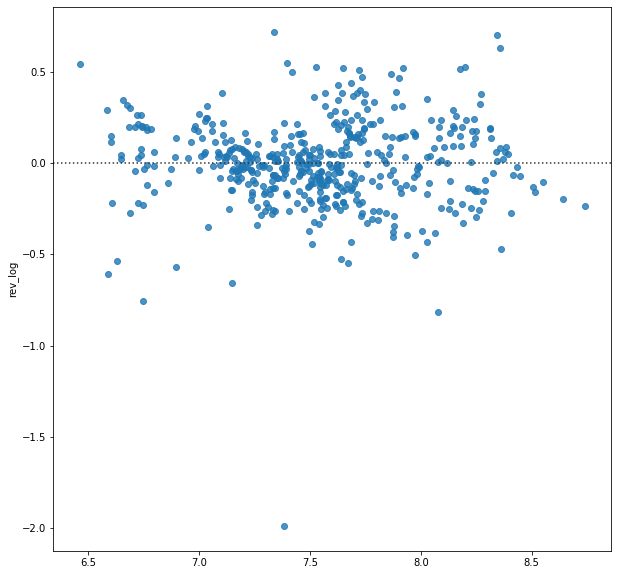

In [38]:
# setting figure size
fig, ax = plt.subplots(figsize = (10, 10))


# developing a residual plot
sns.residplot(x = lr_pred,  # prediction values 
              y = y_test)   # actual values 

# displaying the plot
plt.show()

<strong> Observations:</strong>
- no obvious patterns: homoskedasticity assumption met, linear relationship met
- Caution: very big outlier could be affecting our prediction

<br>
sources: <br>
<a> https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/ <br>
<a> http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/


***

<strong> 2. Evaluating Outlier Affect on Model </strong>

Variables in our model with outliers:
- Total meals ordered
- Largest order size
- Contact with customer service
- Avg prep video time
- Largest order size

Important: Since we are removing outliers, it is important to check how many observations we are removing from our dataset.

In [39]:
# Creating a copy of dataset for safety measure
out_chef = clean_chef.copy()

# Printing out size of dataframe with all data points
print(out_chef.shape)

# Subsetting outliers from our linear model features by using flags
out_chef = out_chef.loc[:][out_chef['out_TOTAL_MEALS_ORDERED'] == 0]
                          
# Printing out size of dataframe after removing outliers
print(out_chef.shape)


(1946, 62)
(1939, 62)


Removed only 7 observations that we outliers in Total Meals Ordered. Total meals ordered is a variable that has a direct relationship with revenue since Revenue = Quantity x Price and Total meals ordered for each customer corresponds to its quantity. Therefore, any outliers could be affecting our model's ability to generalize and predict new data.

In [40]:
# Re-running our linear model without outliers to compare test scores (previous = 0.7832)

# Preparing response variable
out_chef_target = out_chef['rev_log']


### Non-transformed Data ###
# Preparing x-variables
out_chef_x = out_chef[variables_dict['ARD Features']].drop(['REVENUE','rev_log','out_TOTAL_MEALS_ORDERED'],
                                                           axis = 1)# 'out_REVENUE',

# Running train/test split
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(
            out_chef_x,
            out_chef_target,
            test_size = 0.25,
            random_state = seed)


# applying modeling with scikit-learn
# INSTANTIATING a model object
out_lr = LinearRegression()


# FITTING to the training data
out_lr_fit = out_lr.fit(X_train_out, y_train_out) 


# PREDICTING on new data
out_lr_pred = out_lr_fit.predict(X_test_out) 

# SCORING the results
print('Training Score:', out_lr.score(X_train_out, y_train_out).round(4)) 
print('Testing Score:',  out_lr.score(X_test_out, y_test_out).round(4))   

# saving results for later:
out_lr_train_score = out_lr.score(X_train_out, y_train_out).round(4) 
out_lr_test_score  = out_lr.score(X_test_out, y_test_out).round(4)

Training Score: 0.807
Testing Score: 0.8279


In [41]:
# Using StatsModels to print out summary of our best model 
# merging X_train and y_train so that they can be used in statsmodels
chef_train = pd.concat([X_train_out, y_train_out], axis = 1)

# Step 1: build a model
lm_best = smf.ols(formula =  """rev_log ~ chef_train['TOTAL_MEALS_ORDERED'] +
                                chef_train['CONTACTS_W_CUSTOMER_SERVICE'] +
                                chef_train['AVG_PREP_VID_TIME'] +
                                chef_train['LARGEST_ORDER_SIZE'] +
                                chef_train['MEDIAN_MEAL_RATING'] +
                                chef_train['out_CONTACTS_W_CUSTOMER_SERVICE'] +
                                chef_train['change_AVG_PREP_VID_TIME_1'] +
                                chef_train['change_UNIQUE_MEALS_PURCH_0'] +
                                chef_train['change_CONTACTS_W_CUSTOMER_SERVICE_0'] +
                                chef_train['change_MEDIAN_MEAL_RATING_0'] +
                                chef_train['change_MEDIAN_MEAL_RATING_1'] +
                                chef_train['change_MASTER_CLASSES_ATTENDED_0'] +
                                chef_train['change_MASTER_CLASSES_ATTENDED_1'] +
                                chef_train['change_TOTAL_PHOTOS_VIEWED_0']""",
                                data = chef_train)


# Step 2: fit the model based on the data
results = lm_best.fit()


# Step 3: analyze the summary output
#print(results.summary2())

<strong> Observations: </strong>
- outliers were having a large effect on model: new testing score = 0.8279
<br><br>
Let's plot again our residual plot:

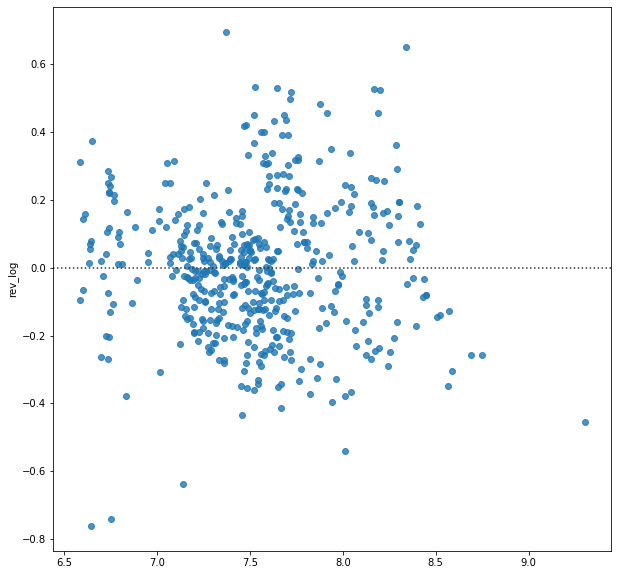

In [43]:
# setting figure size
fig, ax = plt.subplots(figsize = (10, 10))


# developing a residual plot
sns.residplot(x = out_lr_pred,  # prediction values 
              y = y_test_out)   # actual values 

#displaying the plot
plt.show()

<strong> Observations: </strong> 
- there still seems to be a few outliers in our model with really big residual. It is most likely these outlier do not come from our independent variables, and is instead an outlier in Revenue, which is why our model's testing score still increased. 
- for the purpose of this analysis, we will keep the Revenue outliers in our model, since the objective is to identify the best features to predict revenue for a new consumer. Further investigation is needed on this Revenue data point as to understand its relationship in with the selected features.

<strong> 3. Multicollinearity </strong>

Multicollinearity occurs when variables used to predict a target variable are highly correlated amongst themselves. It can be affecting our model since we are double counting, leading to bad predictions and higher standard errors. <br>
Because our model does not have many features, we can use a correlation matrix to identify which variables (if any) are higher correlated.

In [46]:
# correlation matrix
#fig, ax = plt.subplots(figsize=(15,15))

# defining data frame with utilized variables
corr_chef = out_chef.loc[:, variables_dict['ARD Features']].drop(['REVENUE','rev_log'], axis = 1).corr().round(2)

#sns.heatmap(corr_chef,
#            cmap = 'coolwarm',
#            square = True,
#            annot = True,
#            linecolor = 'black',
#            linewidths = 0.5)
#
#plt.show()
corr_chef

,TOTAL_MEALS_ORDERED,CONTACTS_W_CUSTOMER_SERVICE,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MEDIAN_MEAL_RATING,out_TOTAL_MEALS_ORDERED,out_CONTACTS_W_CUSTOMER_SERVICE,change_AVG_PREP_VID_TIME_1,change_UNIQUE_MEALS_PURCH_0,change_CONTACTS_W_CUSTOMER_SERVICE_0,change_MEDIAN_MEAL_RATING_0,change_MEDIAN_MEAL_RATING_1,change_MASTER_CLASSES_ATTENDED_0,change_MASTER_CLASSES_ATTENDED_1,change_TOTAL_PHOTOS_VIEWED_0
TOTAL_MEALS_ORDERED,1.00,-0.06,0.48,0.36,0.48,NaN,-0.03,0.40,-0.13,-0.41,0.07,0.39,0.26,0.16,-0.28
CONTACTS_W_CUSTOMER_SERVICE,-0.06,1.00,0.04,-0.01,-0.02,NaN,0.14,0.04,-0.02,0.70,-0.19,0.19,0.01,-0.02,-0.03
AVG_PREP_VID_TIME,0.48,0.04,1.00,0.80,0.49,NaN,-0.03,0.76,-0.11,-0.31,0.08,0.41,0.31,0.24,-0.27
LARGEST_ORDER_SIZE,0.36,-0.01,0.80,1.00,0.35,NaN,-0.04,0.63,-0.11,-0.23,0.00,0.35,0.23,0.15,-0.21
MEDIAN_MEAL_RATING,0.48,-0.02,0.49,0.35,1.00,NaN,-0.01,0.40,-0.08,-0.40,0.31,0.62,0.32,0.10,-0.37
out_TOTAL_MEALS_ORDERED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
out_CONTACTS_W_CUSTOMER_SERVICE,-0.03,0.14,-0.03,-0.04,-0.01,NaN,1.00,-0.03,-0.01,0.09,-0.00,-0.01,-0.03,0.05,-0.01
change_AVG_PREP_VID_TIME_1,0.40,0.04,0.76,0.63,0.40,NaN,-0.03,1.00,-0.09,-0.24,0.09,0.35,0.30,0.14,-0.24
change_UNIQUE_MEALS_PURCH_0,-0.13,-0.02,-0.11,-0.11,-0.08,NaN,-0.01,-0.09,1.00,0.04,0.03,-0.09,-0.06,0.01,0.06
change_CONTACTS_W_CUSTOMER_SERVICE_0,-0.41,0.70,-0.31,-0.23,-0.40,NaN,0.09,-0.24,0.04,1.00,-0.27,-0.12,-0.23,-0.09,0.21


<strong> Observations: </strong> 
- there are no correlations above 0.8 so we can say that multicollinearity is not affecting our model.

<strong> 4. Re-sampling </strong>

Model performance is dependent on how we split train and testing. Therefore it is important to conduct cross-validation to understand how our model is capable of generalizing when seeing new data. <br>
<br>
source: DataCamp - Supervised Learning with Scikit-Learn

In [ ]:
# Using cross_val_score to store results of cross validation
#cv_results = cross_val_score(out_lr, out_chef_x, out_chef_target, cv = 25)
#
#np.mean(cv_results)
#
# creating lists for cross validation score results
cross_val = []

# building a visualization for different fold numbers
cross_val_settings = range(2, 30)


for n_folds in cross_val_settings:
    # Building the model
    cv_results = cross_val_score(out_lr, out_chef_x, out_chef_target, cv = n_folds)

    # Recording the scores
    cross_val.append(np.mean(cv_results))
#
## plotting the visualization
#fig, ax = plt.subplots(figsize=(12,8))
#plt.plot(cross_val_settings, cross_val, label = "Cross Validation Scores")
#plt.ylabel("score")
#plt.xlabel("number of folds")
#plt.legend()
#plt.show()
#
# finding the optimal number of neighbors
max_score = cross_val.index(max(cross_val)) + 1
print(f"""The max score was achieved at {max_score}""")


In [ ]:
# Finding the highest achieved test score with cross validation
cross_val[11] 

<strong> Observations: </strong> 
- After cross-validation, our model still seems to perform really well to predict Revenue!

## Conclusion

- Our best performing model was a Linear Regression with 15 features with a test score of 0.8279 and a cross validation score with 11 folds at 0.8086
- Optimal features were found using regularization methods such as Lasso and ARD Regression
- It is predicting the log of revenue, therefore when interpreting coefficients, it is important to transform back using 10<sup>(coef)